# Parkinsons Disease detection

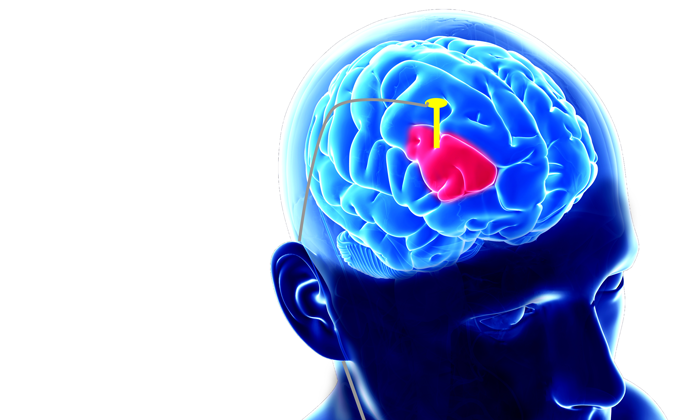

### Parkinson's disease is a brain disorder that leads to shaking, stiffness, and difficulty with walking, balance, and coordination. Parkinson's symptoms usually begin gradually and get worse over time. As the disease progresses, people may have difficulty walking and talking.

Even though there are lot of other tests to be able to find if the person has the Parkinsons disease or not, to be able to detect it in its early stages still seems to be a challenge. Until a mathematician called Max Little who is a research fellow from MIT found out a better way to find the same with 99% accuracy in a 30 second phone call.

Parkinsons can affect the patient's vocal organs in the similar way it affects limbs and hands so just by monitoring the vocal cords in the larynx (vocal box), we are now able to detect if the person has/is developing Parkinsons or not.

In [2]:
# Built-in packages
import json
import warnings
import re
warnings.filterwarnings("ignore")

# Third party packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import iplot

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier


sns.set(context= "notebook", color_codes=True)
plt.style.use('bmh')

pyo.init_notebook_mode()

%matplotlib inline
pd.set_option('display.max_columns', None)

**name**$~~~~~~~~~~~~~~~~~~~~~~~~~$- ASCII subject name and recording number
____
**MDVP:Fo(Hz)**$~~~~~~~~~~~~~$- Average vocal fundamental frequency
____
**MDVP:Fhi(Hz)**$~~~~~~~~~~~~$- Maximum vocal fundamental frequency
____
**MDVP:Flo(Hz)**$~~~~~~~~~~~~$- Minimum vocal fundamental frequency
____
**MDVP:Jitter(%), <br>
MDVP:Jitter(Abs), <br>
MDVP:RAP, <br>
MDVP:PPQ, <br>
Jitter:DDP**$~~~~~~~~~~~~~~~~~~$- Several measures of variation in fundamental frequency
____
**MDVP:Shimmer, <br>
MDVP:Shimmer(dB), <br>
Shimmer:APQ3, <br>
Shimmer:APQ5, <br>
MDVP:APQ, <br>
Shimmer:DDA**$~~~~~~~~~~~~~$- Several measures of variation in amplitude
____
**NHR,HNR**$~~~~~~~~~~~~~~~~~~~$- Two measures of ratio of noise to tonal components in the voice
____
**status**$~~~~~~~~~~~~~~~~~~~~~~~~$- Health status of the subject (one) - Parkinson's, (zero) - healthy
____
**RPDE,D2**$~~~~~~~~~~~~~~~~~~~~$- Two nonlinear dynamical complexity measures
____
**DFA**$~~~~~~~~~~~~~~~~~~~~~~~~~~~$- Signal fractal scaling exponent
____
**spread1, <br>
spread2, <br>
PPE**$~~~~~~~~~~~~~~~~~~~~~~~~~~~$- Three nonlinear measures of fundamental frequency variation
____

In [33]:
# Read the CSV file and display first 10 rows
df = pd.read_csv("Final_data.csv")
df.columns = [i.replace(" ", "_").replace("(%)", "_perc").replace("(dB)", "_db").replace(":", "_").lower() for i in df.columns]
df.columns = [re.sub(r"\((.+)\)", "", i) for i in df.columns]

df

person                        wav_file     mdvp_fo    mdvp_fhi  \
0    phon_R01_S01                               1  119.992000  157.302000   
1    phon_R01_S01                               2  122.400000  148.650000   
2    phon_R01_S01                               3  116.682000  131.111000   
3    phon_R01_S01                               4  116.676000  137.871000   
4    phon_R01_S01                               5  116.014000  141.781000   
..            ...                             ...         ...         ...   
973    Giovanni N  FB1GNIEOGVL47M100220171227.wav  109.480629  169.344661   
974    Giovanni N  VE1GNIEOGVL47M100220171217.wav  117.583634  124.685684   
975    Giovanni N  VE2GNIEOGVL47M100220171217.wav  117.149051  120.438432   
976    Giovanni N  VU1GNIEOGVL47M100220171224.wav  115.155070  132.099881   
977    Giovanni N  VO1GNIEOGVL47M100220171223.wav  111.623954  138.347429   

       mdvp_flo  mdvp_jitter_perc  mdvp_jitter  mdvp_rap  mdvp_ppq  \
0     74.997000          0.007840     0.000070  0.003700  0.005540   
1    113.819000          0.009680     0.000080  0.004650  0.006960   
2    111.555000          0.010500     0.000090  0.005440  0.007810   
3    111.366000          0.009970     0.000090  0.005020  0.006980   
4    110.655000          0.012840     0.000110  0.006550  0.009080   
..          ...               ...          ...       ...       ...   
973   75.000000         18.529456     4.851695  4.851695  6.338581   
974  104.243866          1.874697     0.387523  0.387523  0.500678   
975  114.999626          0.984730     0.356262  0.356262  0.542042   
976  107.920019          1.632779     0.411457  0.411457  0.491512   
977  105.455122          1.762413     0.482239  0.482239  0.548091   

     jitter_ddp  mdvp_shimmer  mdvp_shimmer__db  shimmer_apq3  shimmer_apq5  \
0      0.011090      0.043740          0.426000      0.021820      0.031300   
1      0.013940      0.061340          0.626000      0.031340      0.045180   
2      0.016330      0.052330          0.482000      0.027570      0.038580   
3      0.015050      0.054920          0.517000      0.029240      0.040050   
4      0.019660      0.064250          0.584000      0.034900      0.048250   
..          ...           ...               ...           ...           ...   
973    0.000459      0.001966        -54.128938      0.000437      0.000994   
974    0.002283      0.005436        -45.294518      0.002072      0.004220   
975    0.002757      0.006986        -43.114982      0.002510      0.005021   
976    0.000582      0.003310        -49.604573      0.000500      0.001424   
977    0.001009      0.003759        -48.497448      0.000948      0.002260   

     mdvp_apq  shimmer_dda       nhr        hnr  status          rpde  \
0    0.029710     0.065450  0.022110  21.033000       1  4.147830e-01   
1    0.043680     0.094030  0.019290  19.085000       1  4.583590e-01   
2    0.035900     0.082700  0.013090  20.651000       1  4.298950e-01   
3    0.037720     0.087710  0.013530  20.644000       1  4.349690e-01   
4    0.044650     0.104700  0.017670  19.649000       1  4.173560e-01   
..        ...          ...       ...        ...     ...           ...   
973  0.000002     0.004924  3.613740   0.276722       1 -1.442695e-10   
974  0.000014     0.021001  2.524645   0.396095       1 -1.442695e-10   
975  0.000020     0.026160  2.384145   0.419438       1 -1.442695e-10   
976  0.000003     0.019963  1.997651   0.500588       1 -1.442695e-10   
977  0.000004     0.024436  2.365971   0.422659       1 -1.442695e-10   

       spread1    spread2        d2       ppe language  
0    -4.813031   0.266482  2.301442  0.284654  English  
1    -4.075192   0.335590  2.486855  0.368674  English  
2    -4.443179   0.311173  2.342259  0.332634  English  
3    -4.117501   0.334147  2.405554  0.368975  English  
4    -3.747787   0.234513  2.332180  0.410335  English  
..         ...        ...       ...       ...      ...  
973  20.681959  45.9

In [34]:
df.drop(["wav_file"],axis=1,inplace=True)
print(f"The shape of the DatFrame is: {df.shape}, which means there are {df.shape[0]} rows and {df.shape[1]} columns.")

The shape of the DatFrame is: (978, 24), which means there are 978 rows and 24 columns.


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            978 non-null    object 
 1   mdvp_fo           978 non-null    float64
 2   mdvp_fhi          978 non-null    float64
 3   mdvp_flo          978 non-null    float64
 4   mdvp_jitter_perc  978 non-null    float64
 5   mdvp_jitter       978 non-null    float64
 6   mdvp_rap          978 non-null    float64
 7   mdvp_ppq          978 non-null    float64
 8   jitter_ddp        978 non-null    float64
 9   mdvp_shimmer      978 non-null    float64
 10  mdvp_shimmer__db  978 non-null    float64
 11  shimmer_apq3      978 non-null    float64
 12  shimmer_apq5      978 non-null    float64
 13  mdvp_apq          978 non-null    float64
 14  shimmer_dda       978 non-null    float64
 15  nhr               978 non-null    float64
 16  hnr               978 non-null    float64
 1

In [36]:
# Check if any of the columns have null values
print(df.isnull().sum())

person               0
mdvp_fo              0
mdvp_fhi             0
mdvp_flo             0
mdvp_jitter_perc     0
mdvp_jitter          0
mdvp_rap             0
mdvp_ppq             0
jitter_ddp           0
mdvp_shimmer         0
mdvp_shimmer__db     0
shimmer_apq3         0
shimmer_apq5         0
mdvp_apq             0
shimmer_dda          0
nhr                  0
hnr                  0
status               0
rpde                 0
spread1              0
spread2              0
d2                   0
ppe                 12
language             0
dtype: int64


In [37]:
df.dropna(inplace=True)

In [38]:
df_summary = df.describe()
df_summary

mdvp_fo    mdvp_fhi    mdvp_flo  mdvp_jitter_perc  mdvp_jitter  \
count  966.000000  966.000000  966.000000        966.000000   966.000000   
mean   158.213850  211.762926  119.214758          7.723959     2.117064   
std     39.169959   90.024722   42.617790         10.253074     2.682428   
min     86.257127   90.749557   65.476000          0.001680     0.000007   
25%    126.140008  150.112250   79.845009          1.038755     0.370720   
50%    154.395104  193.071000  110.442529          2.592335     0.818836   
75%    183.231537  240.876865  149.365516         12.872581     3.509939   
max    484.880130  600.000000  470.750459         69.253350    23.962757   

         mdvp_rap    mdvp_ppq  jitter_ddp  mdvp_shimmer  mdvp_shimmer__db  \
count  966.000000  966.000000  966.000000    966.000000        966.000000   
mean     2.117700    2.838698    0.003231      0.008566        -44.739310   
std      2.681926    3.736684    0.005581      0.013870         24.987990   
min      0.000680    0.000920    0.000014      0.000011        -99.458189   
25%      0.370720    0.530260    0.000351      0.000918        -60.746518   
50%      0.818836    0.964010    0.001152      0.002719        -51.310830   
75%      3.509939    4.787716    0.003932      0.009542        -40.256151   
max     23.962757   44.243249    0.064330      0.119080          1.302000   

       shimmer_apq3  shimmer_apq5      mdvp_apq  shimmer_dda            nhr  \
count    966.000000    966.000000  9.660000e+02   966.000000     966.000000   
mean       0.004520      0.007204  4.742325e-03     0.020421     409.056002   
std        0.007534      0.010469  1.193491e-02     0.020804    8410.607227   
min        0.000022      0.000060  3.277792e-10     0.000539       0.000650   
25%        0.000367      0.000937  8.503211e-07     0.006194       1.905920   
50%        0.001281      0.003129  6.843551e-06     0.015591       2.293432   
75%        0.005093      0.009726  9.777715e-05     0.025661       3.235168   
max        0.056470      0.106685  1.377800e-01     0.169420  228779.330000   

              hnr      status          rpde     spread1     spread2  \
count  966.000000  966.000000  9.660000e+02  966.000000  966.000000   
mean     4.657184    0.589027  9.894075e-02   10.628799   26.155271   
std      8.839657    0.492265  2.040423e-01   20.133119   40.123716   
min      0.000004    0.000000 -1.442695e-10   -7.964984    0.006274   
25%      0.309103    0.000000 -1.442695e-10    1.537661    3.117054   
50%      0.436028    1.000000 -1.442695e-10    3.343426    7.009640   
75%      0.524681    1.000000 -1.442695e-10   14.235327   37.385115   
max     33.047000    1.000000  6.851510e-01  148.697938  369.212867   

               d2         ppe  
count  966.000000  966.000000  
mean     0.612740    0.044455  
std      0.914813    0.090279  
min      0.005576    0.000000  
25%      0.035088    0.000000  
50%      0.164334   -0.000000  
75%      0.651348    0.023006  
max      3.671155    0.527367

In [28]:
df.drop_duplicates(inplace=True)

In [39]:
df.drop(["ppe"],axis=1,inplace=True)
df.drop(["person"],axis=1,inplace=True)

In [40]:
df.isna().sum()

mdvp_fo             0
mdvp_fhi            0
mdvp_flo            0
mdvp_jitter_perc    0
mdvp_jitter         0
mdvp_rap            0
mdvp_ppq            0
jitter_ddp          0
mdvp_shimmer        0
mdvp_shimmer__db    0
shimmer_apq3        0
shimmer_apq5        0
mdvp_apq            0
shimmer_dda         0
nhr                 0
hnr                 0
status              0
rpde                0
spread1             0
spread2             0
d2                  0
language            0
dtype: int64

In [42]:
df.drop(["language"],axis=1,inplace=True)

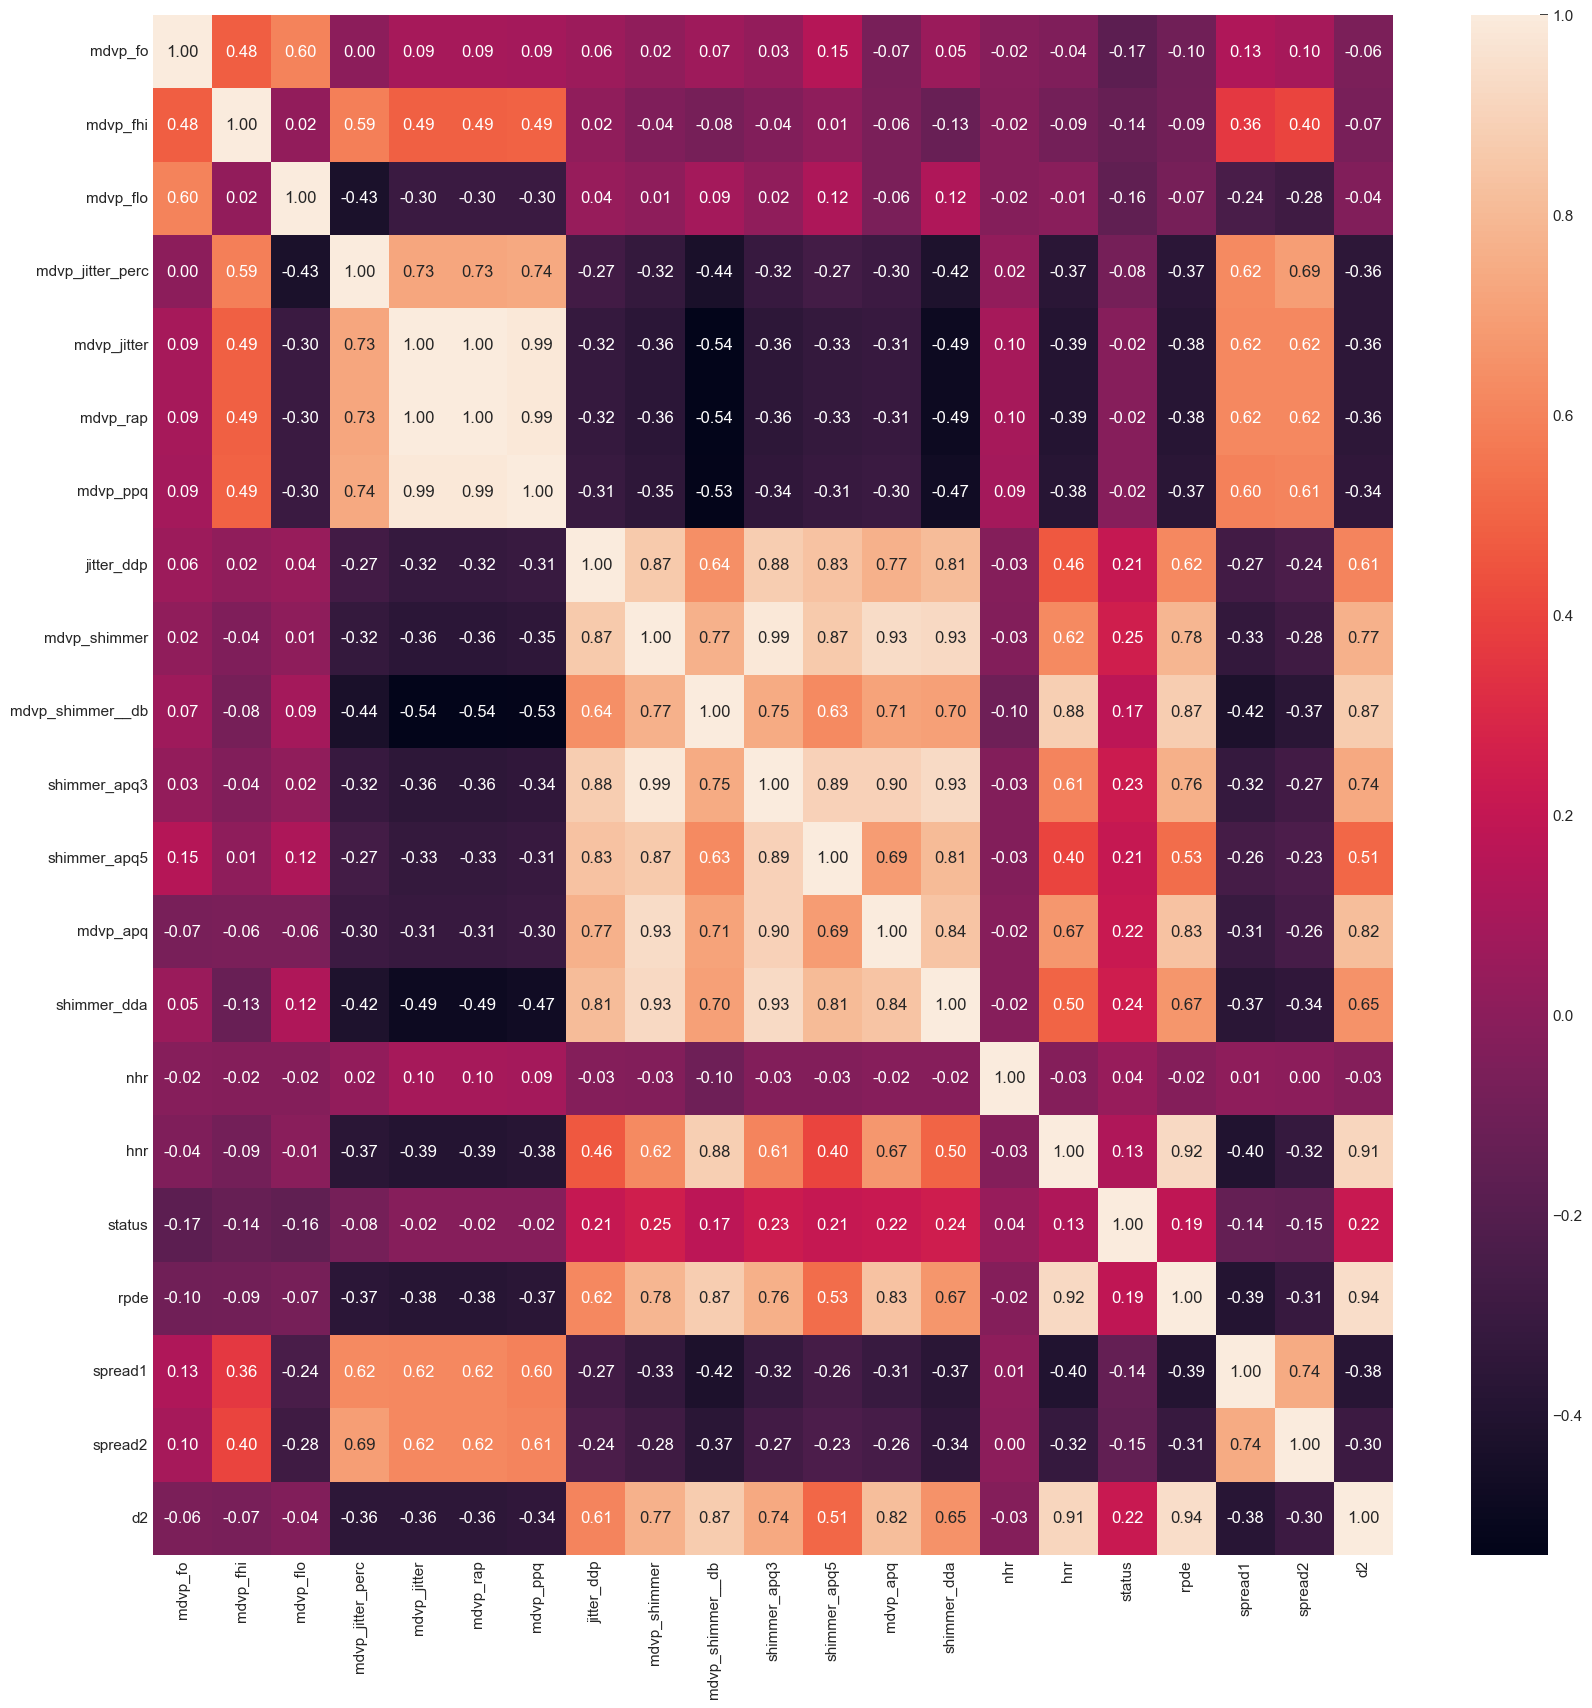

In [43]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), fmt='.2f', annot=True);

## Univariate and Bivariate analysis

In [44]:
# A function that returns value counts for a column split by status
def groupby_get_cc_count(tdf, col):
    tdf = tdf.groupby([col, "status"])["status"].count().reset_index(level = 0)
    tdf.columns = [col, "count"]
    tdf = tdf.reset_index()
    return tdf

In [45]:
df[["mdvp_fo", "mdvp_jitter", "status"]]

mdvp_fo  mdvp_jitter  status
0    119.992000     0.000070       1
1    122.400000     0.000080       1
2    116.682000     0.000090       1
3    116.676000     0.000090       1
4    116.014000     0.000110       1
..          ...          ...     ...
973  109.480629     4.851695       1
974  117.583634     0.387523       1
975  117.149051     0.356262       1
976  115.155070     0.411457       1
977  111.623954     0.482239       1

[966 rows x 3 columns]

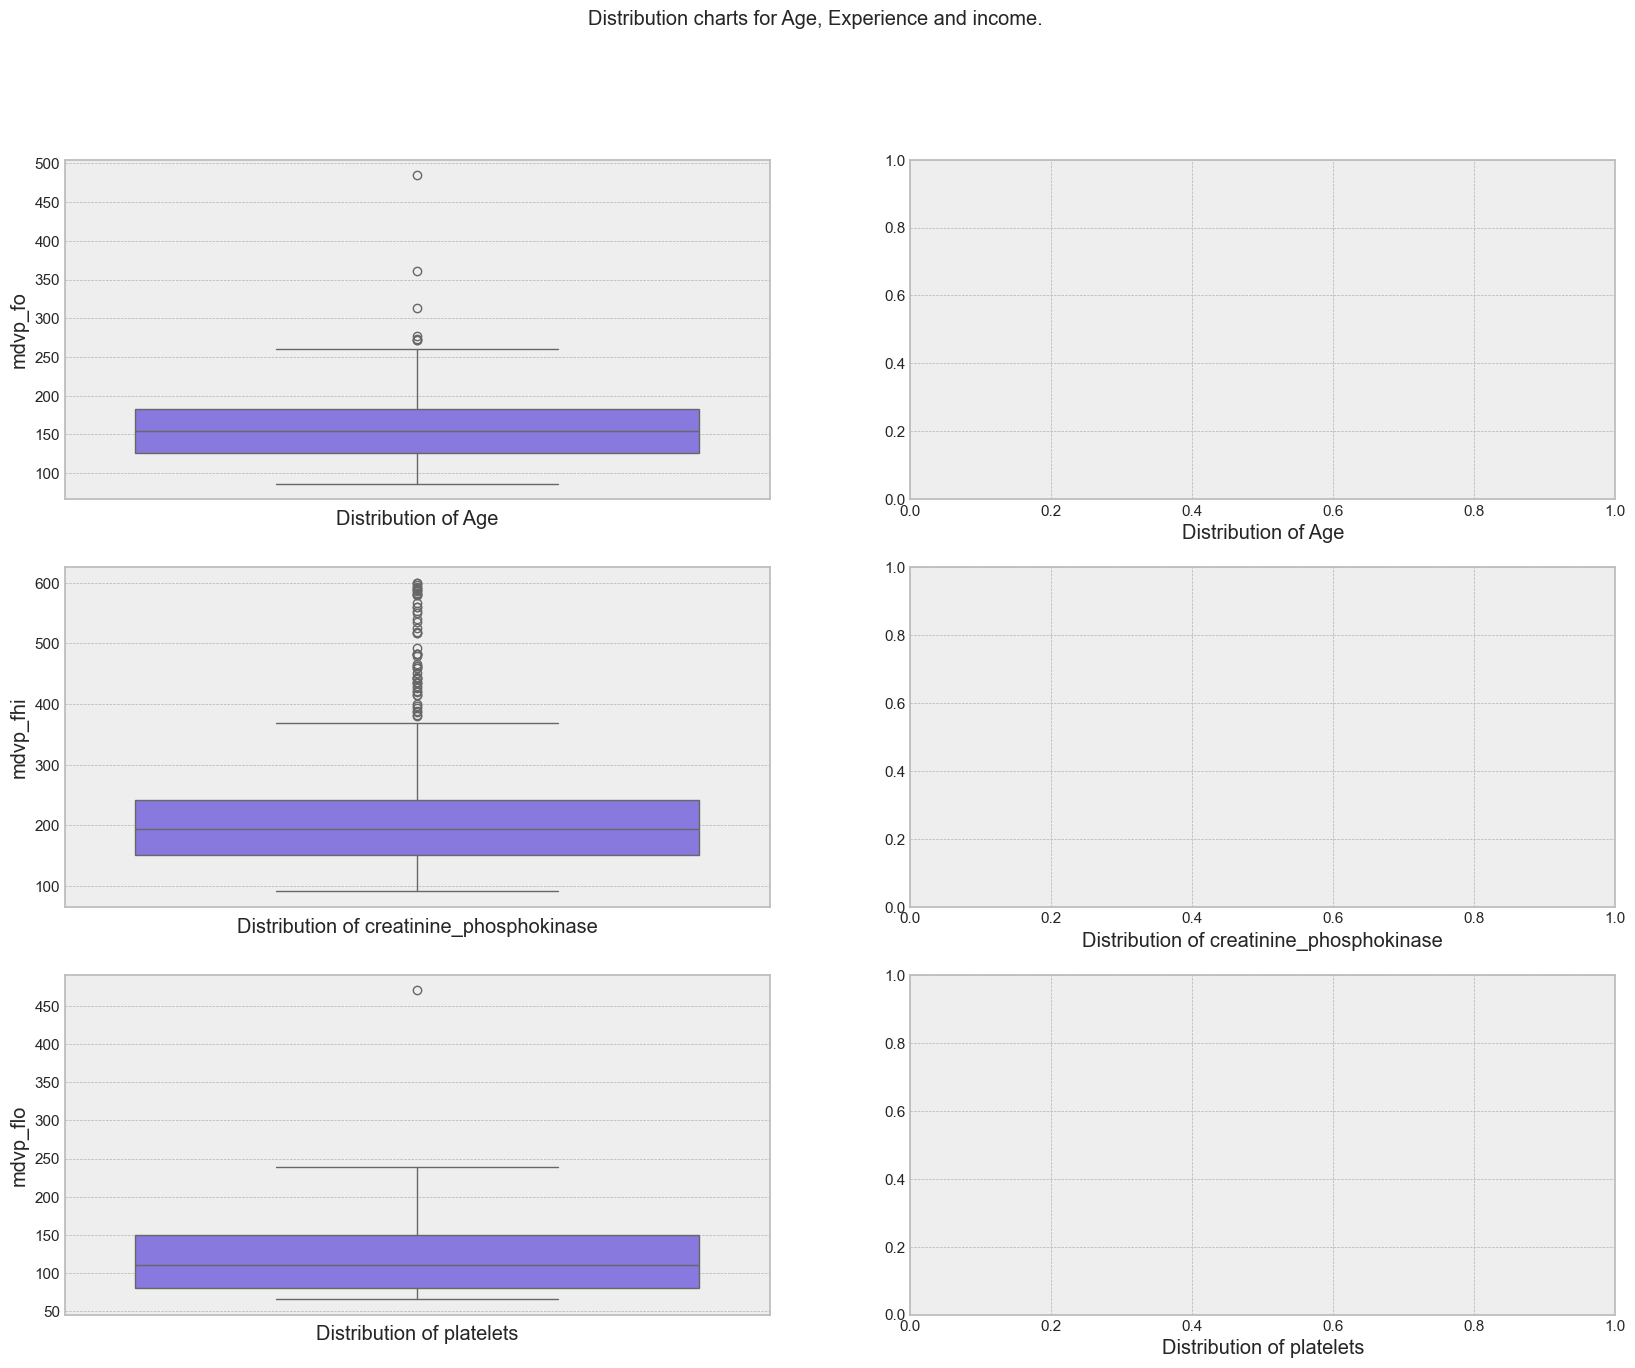

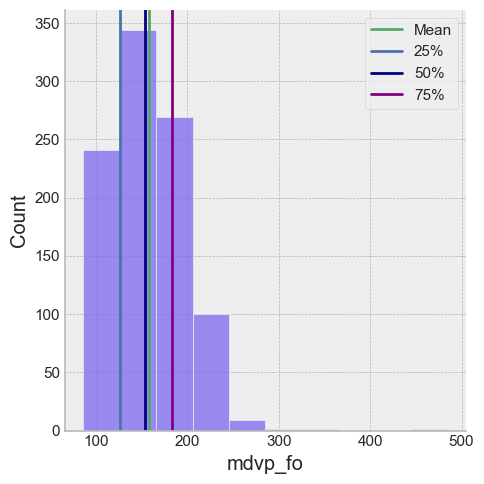

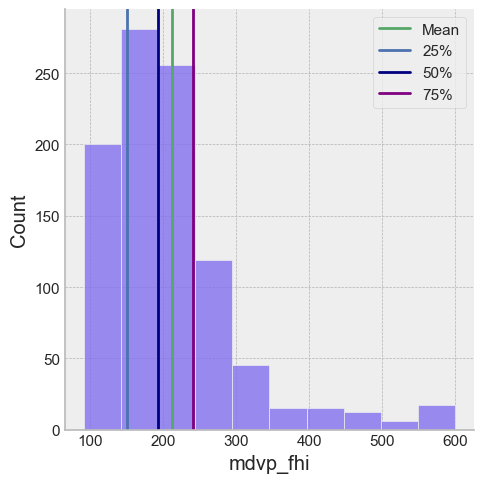

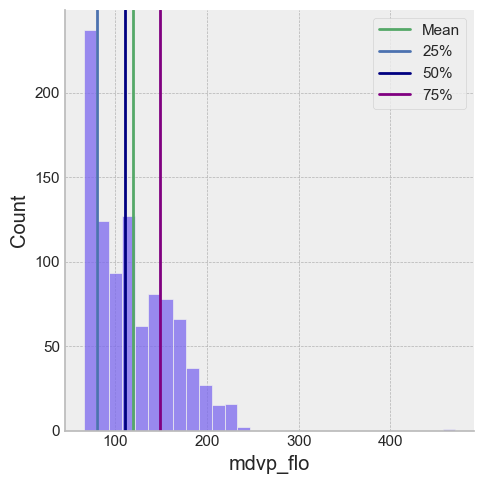

In [50]:
def draw_axvlines(col):
    mean = df_summary.loc["mean", col]
    q1 = df_summary.loc["25%", col]
    q2 = df_summary.loc["50%", col]
    q3 = df_summary.loc["75%", col]
    plt.axvline(mean, color = "g");              # Plotting a line to mark the mean 
    plt.axvline(q1, color = "b");                # Plotting a line to mark Q1 
    plt.axvline(q2, color = "navy");             # Plotting a line to mark Q2 
    plt.axvline(q3, color = "purple");           # Plotting a line to mark Q3
    plt.legend({"Mean": mean, "25%" : q1, "50%" : q2, "75%" : q3});

fig, axes = plt.subplots(3, 2, figsize = (20,15));
fig.suptitle('Distribution charts for Age, Experience and income.');


# Create boxplot to show distribution of Age
sns.boxplot(df["mdvp_fo"], ax = axes[0][0], color = "mediumslateblue");
axes[0][0].set(xlabel = 'Distribution of Age');

pp = sns.displot(df["mdvp_fo"], ax = axes[0][1], bins = 10, color = "mediumslateblue");
axes[0][1].set(xlabel = 'Distribution of Age');
draw_axvlines("mdvp_fo");


# Create boxplot to show distribution of creatinine_phosphokinase
sns.boxplot(df["mdvp_fhi"], ax = axes[1][0], color = "mediumslateblue");
axes[1][0].set(xlabel = 'Distribution of creatinine_phosphokinase');

pp = sns.displot(df["mdvp_fhi"], ax = axes[1][1], bins = 10, color = "mediumslateblue");
axes[1][1].set(xlabel = 'Distribution of creatinine_phosphokinase');
draw_axvlines("mdvp_fhi")


# Create boxplot to show distribution of platelets
sns.boxplot(df["mdvp_flo"], ax = axes[2][0], color = "mediumslateblue");
axes[2][0].set(xlabel = 'Distribution of platelets');

pp = sns.displot(df["mdvp_flo"], ax = axes[2][1], color = "mediumslateblue");
axes[2][1].set(xlabel = 'Distribution of platelets');
draw_axvlines("mdvp_flo")

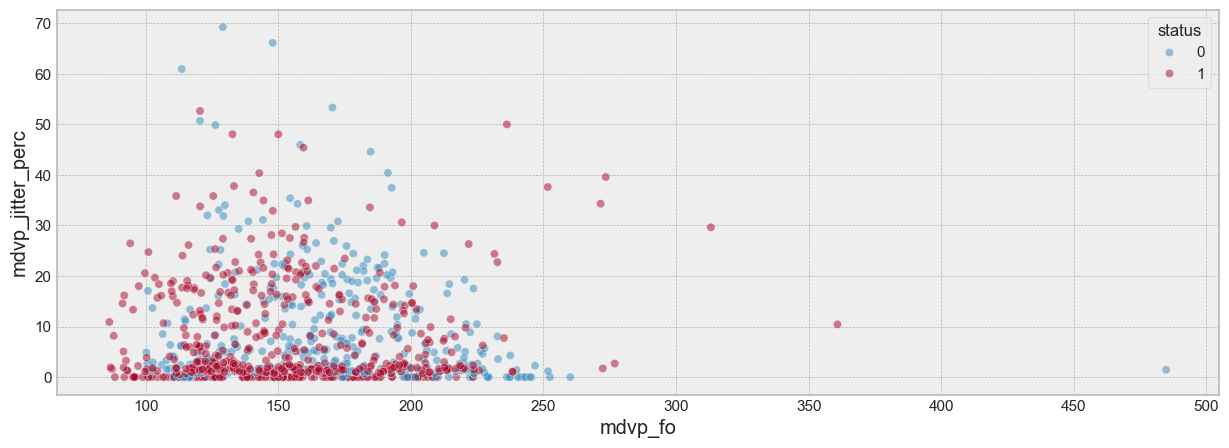

In [51]:
plt.figure(figsize = (15, 5))
sns.scatterplot(x = "mdvp_fo", y = "mdvp_jitter_perc", data = df[["mdvp_fo", "mdvp_jitter_perc", "status"]], hue = "status", alpha = 0.5);

From the above plot, we can see that the people without Parkinsons have their fundamental frequencies that is either high or very low and the percentage of jitter is usually lower that 0.005%.

In [101]:
# df_train = df.copy().drop(columns=["name"])
df_train = df.copy()
col_names = df_train.columns.tolist()
target_col = ["status"]
col_names.remove(target_col[0])


In [102]:
df_train

mdvp_fo    mdvp_fhi    mdvp_flo  mdvp_jitter_perc  mdvp_jitter  \
0    119.992000  157.302000   74.997000          0.007840     0.000070   
1    122.400000  148.650000  113.819000          0.009680     0.000080   
2    116.682000  131.111000  111.555000          0.010500     0.000090   
3    116.676000  137.871000  111.366000          0.009970     0.000090   
4    116.014000  141.781000  110.655000          0.012840     0.000110   
..          ...         ...         ...               ...          ...   
973  109.480629  169.344661   75.000000         18.529456     4.851695   
974  117.583634  124.685684  104.243866          1.874697     0.387523   
975  117.149051  120.438432  114.999626          0.984730     0.356262   
976  115.155070  132.099881  107.920019          1.632779     0.411457   
977  111.623954  138.347429  105.455122          1.762413     0.482239   

     mdvp_rap  mdvp_ppq  jitter_ddp  mdvp_shimmer  mdvp_shimmer__db  \
0    0.003700  0.005540    0.011090      0.043740          0.426000   
1    0.004650  0.006960    0.013940      0.061340          0.626000   
2    0.005440  0.007810    0.016330      0.052330          0.482000   
3    0.005020  0.006980    0.015050      0.054920          0.517000   
4    0.006550  0.009080    0.019660      0.064250          0.584000   
..        ...       ...         ...           ...               ...   
973  4.851695  6.338581    0.000459      0.001966        -54.128938   
974  0.387523  0.500678    0.002283      0.005436        -45.294518   
975  0.356262  0.542042    0.002757      0.006986        -43.114982   
976  0.411457  0.491512    0.000582      0.003310        -49.604573   
977  0.482239  0.548091    0.001009      0.003759        -48.497448   

     shimmer_apq3  shimmer_apq5  mdvp_apq  shimmer_dda       nhr        hnr  \
0        0.021820      0.031300  0.029710     0.065450  0.022110  21.033000   
1        0.031340      0.045180  0.043680     0.094030  0.019290  19.085000   
2        0.027570      0.038580  0.035900     0.082700  0.013090  20.651000   
3        0.029240      0.040050  0.037720     0.087710  0.013530  20.644000   
4        0.034900      0.048250  0.044650     0.104700  0.017670  19.649000   
..            ...           ...       ...          ...       ...        ...   
973      0.000437      0.000994  0.000002     0.004924  3.613740   0.276722   
974      0.002072      0.004220  0.000014     0.021001  2.524645   0.396095   
975      0.002510      0.005021  0.000020     0.026160  2.384145   0.419438   
976      0.000500      0.001424  0.000003     0.019963  1.997651   0.500588   
977      0.000948      0.002260  0.000004     0.024436  2.365971   0.422659   

     status          rpde    spread1    spread2        d2  
0         1  4.147830e-01  -4.813031   0.266482  2.301442  
1         1  4.583590e-01  -4.075192   0.335590  2.486855  
2         1  4.298950e-01  -4.443179   0.311173  2.342259  
3         1  4.349690e-01  -4.117501   0.334147  2.405554  
4         1  4.173560e-01  -3.747787   0.234513  2.332180  
..      ...           ...        ...        ...       ...  
973       1 -1.442695e-10  20.681959  45.920800  0.238455  
974       1 -1.442695e-10   1.328195   2.862934  0.032206  
975       1 -1.442695e-10   1.532805   2.832705  0.919261  
976       1 -1.442695e-10   1.385324   2.844660  0.045541  
977       1 -1.442695e-10   1.742920   3.448863  0.114488  

[966 rows x 21 columns]

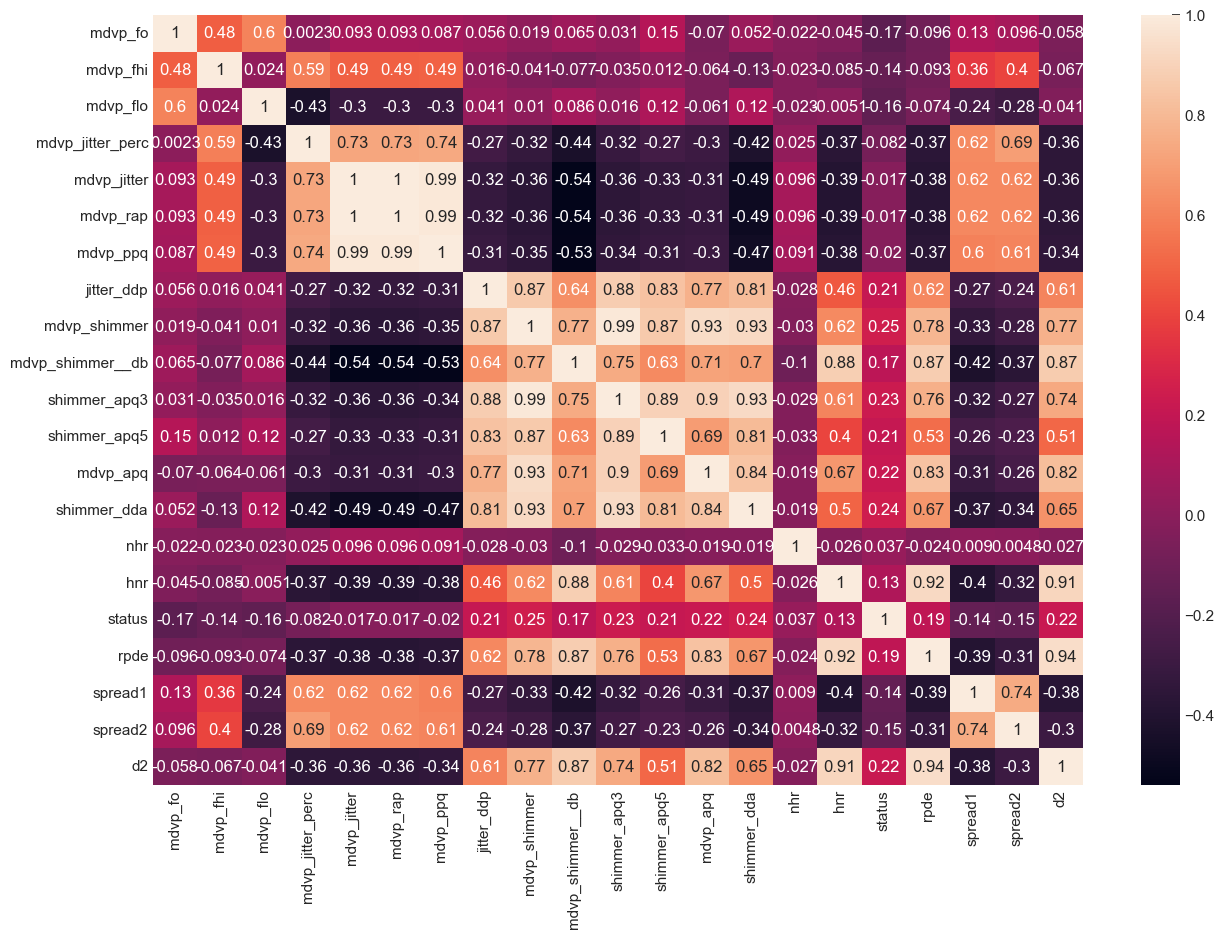

In [97]:
plt.figure(figsize=(15,10))
corr = df_train.corr()
sns.heatmap(corr, annot=True, fmt='.2g');

## Standardization (Scaling)

In [98]:
len(df_train[col_names].columns)

20

In [104]:
std = StandardScaler()

scaled = std.fit_transform(df_train[col_names])     # Standardize the columns to get them on the same scale
scaled = pd.DataFrame(scaled, columns=col_names)  # Convert the array back to a DataFrame
scaled

mdvp_fo  mdvp_fhi  mdvp_flo  mdvp_jitter_perc  mdvp_jitter  mdvp_rap  \
0   -0.976300 -0.605269 -1.038080         -0.752956    -0.789617 -0.788648   
1   -0.914793 -0.701425 -0.126674         -0.752777    -0.789613 -0.788294   
2   -1.060848 -0.896350 -0.179825         -0.752697    -0.789610 -0.787999   
3   -1.061001 -0.821221 -0.184262         -0.752748    -0.789610 -0.788156   
4   -1.077910 -0.777766 -0.200953         -0.752468    -0.789602 -0.787585   
..        ...       ...       ...               ...          ...       ...   
961 -1.244792 -0.471429 -1.038009          1.054425     1.019989  1.019943   
962 -1.037817 -0.967760 -0.351465         -0.570784    -0.645101 -0.645459   
963 -1.048918 -1.014963 -0.098957         -0.657629    -0.656761 -0.657121   
964 -1.099850 -0.885360 -0.265161         -0.594391    -0.636174 -0.636530   
965 -1.190045 -0.815926 -0.323029         -0.581741    -0.609773 -0.610125   

     mdvp_ppq  jitter_ddp  mdvp_shimmer  mdvp_shimmer__db  shimmer_apq3  \
0   -0.758594    1.408949      2.537238          1.808417      2.297285   
1   -0.758214    1.919865      3.806783          1.816425      3.561485   
2   -0.757986    2.348317      3.156863          1.810659      3.060851   
3   -0.758208    2.118853      3.343688          1.812061      3.282617   
4   -0.757646    2.945283      4.016690          1.814743      4.034232   
..        ...         ...           ...               ...           ...   
961  0.937113   -0.496793     -0.476064         -0.375960     -0.542238   
962 -0.626018   -0.169869     -0.225757         -0.022231     -0.325083   
963 -0.614942   -0.084883     -0.113919          0.065038     -0.266908   
964 -0.628472   -0.474885     -0.379138         -0.194805     -0.533861   
965 -0.613323   -0.398291     -0.346685         -0.150476     -0.474458   

     shimmer_apq5  mdvp_apq  shimmer_dda       nhr       hnr      rpde  \
0        2.302801  2.093071     2.165583 -0.048658  1.853499  1.548727   
1        3.629292  3.264193     3.540086 -0.048659  1.633015  1.762401   
2        2.998540  2.611986     2.995191 -0.048659  1.810263  1.622829   
3        3.139026  2.764559     3.236137 -0.048659  1.809470  1.647709   
4        3.922688  3.345510     4.053240 -0.048659  1.696851  1.561344   
..            ...       ...          ...       ...       ...       ...   
961     -0.593515 -0.397375    -0.745324 -0.048231 -0.495803 -0.485154   
962     -0.285233 -0.396360     0.027879 -0.048361 -0.482292 -0.485154   
963     -0.208676 -0.395905     0.275984 -0.048377 -0.479650 -0.485154   
964     -0.552447 -0.397284    -0.022031 -0.048423 -0.470465 -0.485154   
965     -0.472515 -0.397250     0.193079 -0.048379 -0.479285 -0.485154   

      spread1   spread2        d2  
0   -0.767384 -0.645558  1.846910  
1   -0.730717 -0.643835  2.049694  
2   -0.749004 -0.644444  1.891551  
3   -0.732819 -0.643871  1.960776  
4   -0.714446 -0.646356  1.880528  
..        ...       ...       ...  
961  0.499593  0.492870 -0.409350  
962 -0.462195 -0.580814 -0.634922  
963 -0.452027 -0.581567  0.335238  
964 -0.459356 -0.581269 -0.620337  
965 -0.441585 -0.566203 -0.544931  

[966 rows x 20 columns]

In [106]:
# Reset the indices of both the DataFrame and the Series before concatenating
df_train = pd.concat([scaled.reset_index(drop=True), df_train[target_col].reset_index(drop=True)], axis=1)
df_train


mdvp_fo  mdvp_fhi  mdvp_flo  mdvp_jitter_perc  mdvp_jitter  mdvp_rap  \
0   -0.976300 -0.605269 -1.038080         -0.752956    -0.789617 -0.788648   
1   -0.914793 -0.701425 -0.126674         -0.752777    -0.789613 -0.788294   
2   -1.060848 -0.896350 -0.179825         -0.752697    -0.789610 -0.787999   
3   -1.061001 -0.821221 -0.184262         -0.752748    -0.789610 -0.788156   
4   -1.077910 -0.777766 -0.200953         -0.752468    -0.789602 -0.787585   
..        ...       ...       ...               ...          ...       ...   
961 -1.244792 -0.471429 -1.038009          1.054425     1.019989  1.019943   
962 -1.037817 -0.967760 -0.351465         -0.570784    -0.645101 -0.645459   
963 -1.048918 -1.014963 -0.098957         -0.657629    -0.656761 -0.657121   
964 -1.099850 -0.885360 -0.265161         -0.594391    -0.636174 -0.636530   
965 -1.190045 -0.815926 -0.323029         -0.581741    -0.609773 -0.610125   

     mdvp_ppq  jitter_ddp  mdvp_shimmer  mdvp_shimmer__db  shimmer_apq3  \
0   -0.758594    1.408949      2.537238          1.808417      2.297285   
1   -0.758214    1.919865      3.806783          1.816425      3.561485   
2   -0.757986    2.348317      3.156863          1.810659      3.060851   
3   -0.758208    2.118853      3.343688          1.812061      3.282617   
4   -0.757646    2.945283      4.016690          1.814743      4.034232   
..        ...         ...           ...               ...           ...   
961  0.937113   -0.496793     -0.476064         -0.375960     -0.542238   
962 -0.626018   -0.169869     -0.225757         -0.022231     -0.325083   
963 -0.614942   -0.084883     -0.113919          0.065038     -0.266908   
964 -0.628472   -0.474885     -0.379138         -0.194805     -0.533861   
965 -0.613323   -0.398291     -0.346685         -0.150476     -0.474458   

     shimmer_apq5  mdvp_apq  shimmer_dda       nhr       hnr      rpde  \
0        2.302801  2.093071     2.165583 -0.048658  1.853499  1.548727   
1        3.629292  3.264193     3.540086 -0.048659  1.633015  1.762401   
2        2.998540  2.611986     2.995191 -0.048659  1.810263  1.622829   
3        3.139026  2.764559     3.236137 -0.048659  1.809470  1.647709   
4        3.922688  3.345510     4.053240 -0.048659  1.696851  1.561344   
..            ...       ...          ...       ...       ...       ...   
961     -0.593515 -0.397375    -0.745324 -0.048231 -0.495803 -0.485154   
962     -0.285233 -0.396360     0.027879 -0.048361 -0.482292 -0.485154   
963     -0.208676 -0.395905     0.275984 -0.048377 -0.479650 -0.485154   
964     -0.552447 -0.397284    -0.022031 -0.048423 -0.470465 -0.485154   
965     -0.472515 -0.397250     0.193079 -0.048379 -0.479285 -0.485154   

      spread1   spread2        d2  status  
0   -0.767384 -0.645558  1.846910       1  
1   -0.730717 -0.643835  2.049694       1  
2   -0.749004 -0.644444  1.891551       1  
3   -0.732819 -0.643871  1.960776       1  
4   -0.714446 -0.646356  1.880528       1  
..        ...       ...       ...     ...  
961  0.499593  0.492870 -0.409350       1  
962 -0.462195 -0.580814 -0.634922       1  
963 -0.452027 -0.581567  0.335238       1  
964 -0.459356 -0.581269 -0.620337       1  
965 -0.441585 -0.566203 -0.544931       1  

[966 rows x 21 columns]

## Test AND Train split 70:30 ratio

In [107]:
X = df_train[col_names]      # Contains the independent columns 
y = df_train[target_col]     # Our target column

In [108]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 323)
train_y = train_y["status"]
test_y = test_y["status"]

In [111]:
conf_matrix_all = {}

def parkinsons_disease_prediction(name, algo, training_x, testing_x, training_y, testing_y, plot) :
    algo.fit(training_x,training_y)                           # Fit the training data set to the algorithm passed.
    predictions = algo.predict(testing_x)                     # Get all predictions
    probabilities = algo.predict_proba(testing_x)             # Get probablities of predictions

    conf_matrix = confusion_matrix(testing_y, predictions)    # Get confusion matrix using the predictions
    tn, fp, fn, tp = conf_matrix.ravel()
    
    conf_matrix_all[name] = conf_matrix                       # Save confusion matrix values to a dictionary
    
    print("Classification report:")                           # Print the classification report
    print(classification_report(testing_y, predictions))
  
    model_roc_auc = roc_auc_score(testing_y, predictions)           # Get the Area under the curve number
    fpr,tpr,thresholds = roc_curve(testing_y, probabilities[:,1])   # Get False postive rate and true positive rate
    
    print ("Area under the curve: ", model_roc_auc)
    
    
    if plot:
        fig, axes = plt.subplots(1,2, figsize=(20, 7))
        conf_matrix = np.flip(conf_matrix)
        
        labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
        labels = np.core.defchararray.add(conf_matrix.astype(str), labels)
        sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[0], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);                                           # Plot the confusion matrix
        axes[0].set(xlabel='Predicted', ylabel='Actual')

        plt.title('Receiver Operating Characteristic')
        sns.lineplot(x=fpr, y=tpr, ax=axes[1])                                         # Plot the ROC curve
        plt.plot([0, 1], [0, 1],'--')                                              # Plot the diagonal line
        axes[1].set_xlim([0, 1])                                                   # Set x-axis limit to 0 and 1
        axes[1].set_ylim([0, 1])                                                   # Set y-axis limit to 0 and 1
        axes[1].set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate');
        plt.show();

### Logistic Regression

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       118
           1       0.72      0.76      0.74       172

    accuracy                           0.69       290
   macro avg       0.67      0.67      0.67       290
weighted avg       0.68      0.69      0.68       290

Area under the curve:  0.6689495467087111


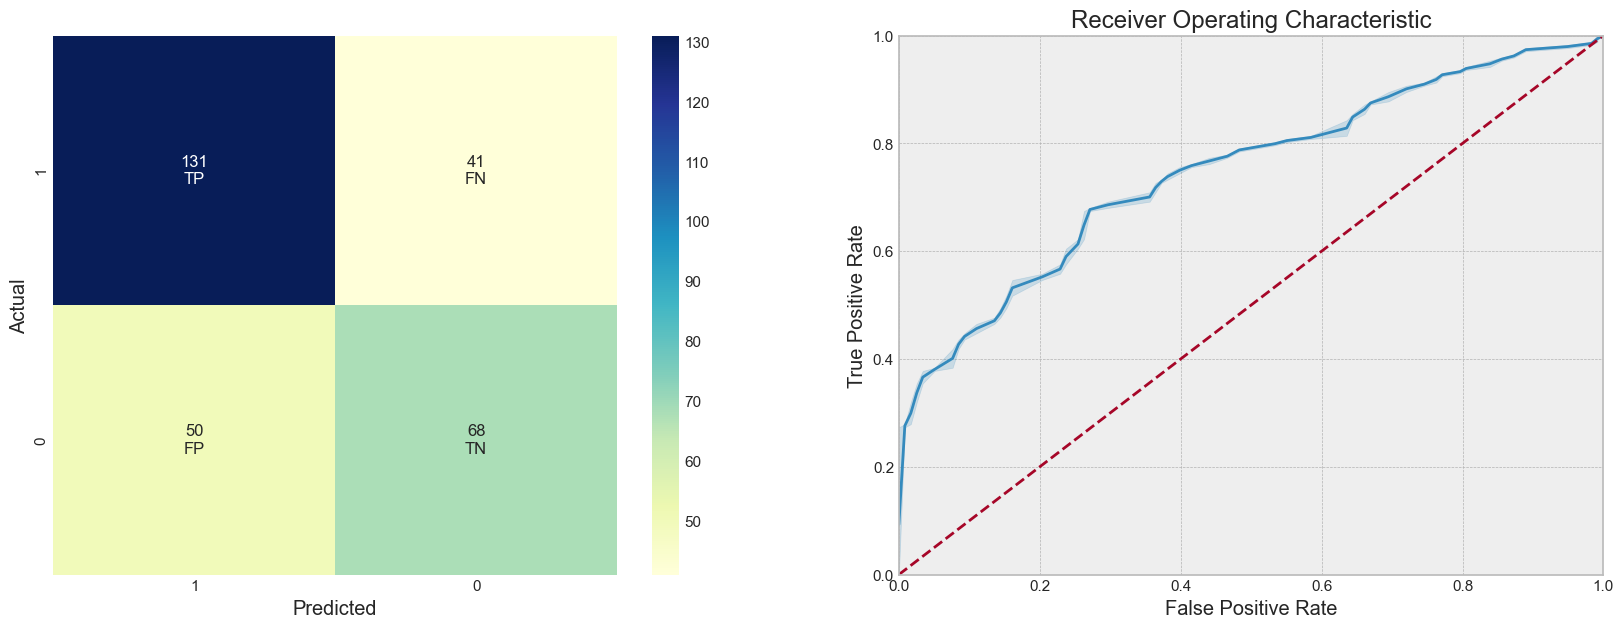

In [112]:
lr  = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, penalty="l1", solver='liblinear')

parkinsons_disease_prediction("Logistic Regression", lr, train_X, test_X, train_y, test_y, plot = True)

### K-nearest Neighbors

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       118
           1       0.81      0.77      0.79       172

    accuracy                           0.76       290
   macro avg       0.75      0.76      0.75       290
weighted avg       0.76      0.76      0.76       290

Area under the curve:  0.7566022861647616


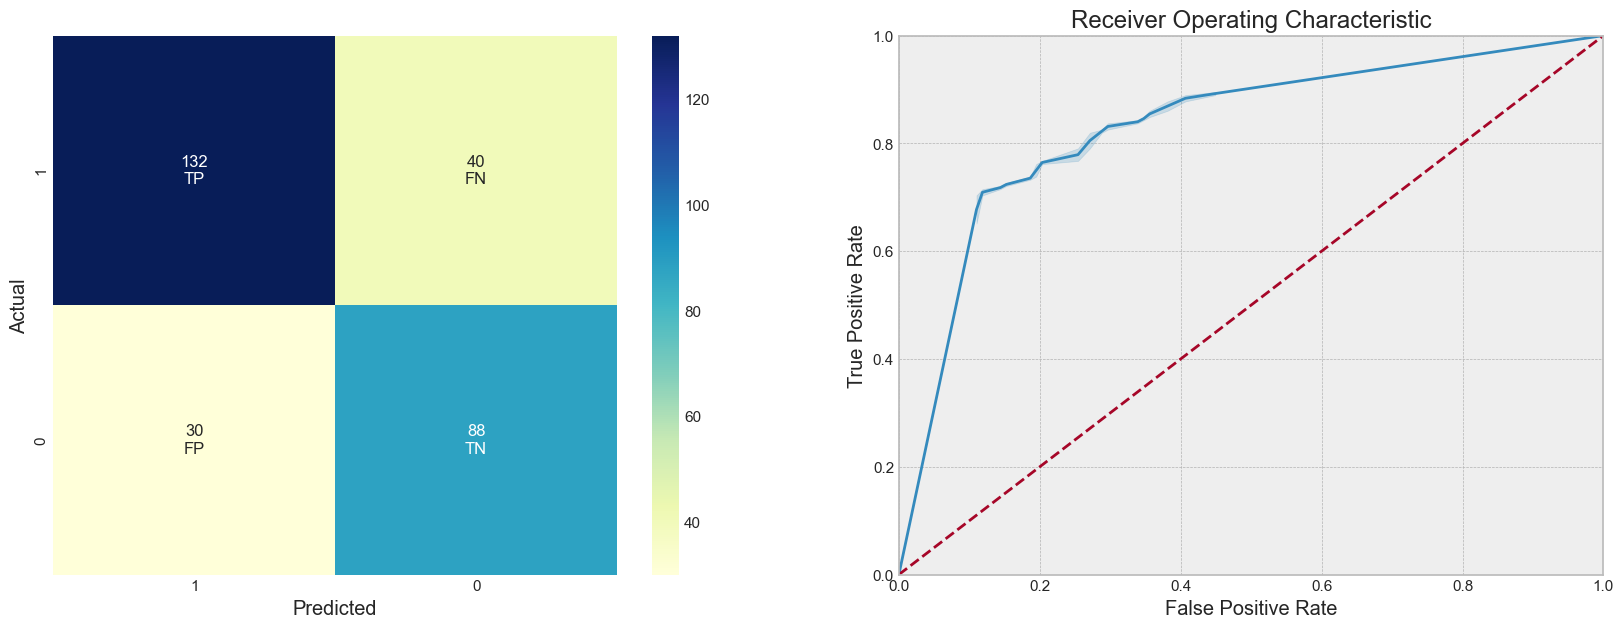

In [113]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', metric_params=None, n_neighbors = 2, weights='distance')

parkinsons_disease_prediction("K-Nearest Neighbours", knn, train_X, test_X, train_y, test_y, plot=True)

### Naïve Bayes

Classification report:
              precision    recall  f1-score   support

           0       0.44      0.84      0.58       118
           1       0.71      0.27      0.39       172

    accuracy                           0.50       290
   macro avg       0.58      0.56      0.49       290
weighted avg       0.60      0.50      0.47       290

Area under the curve:  0.556119432400473


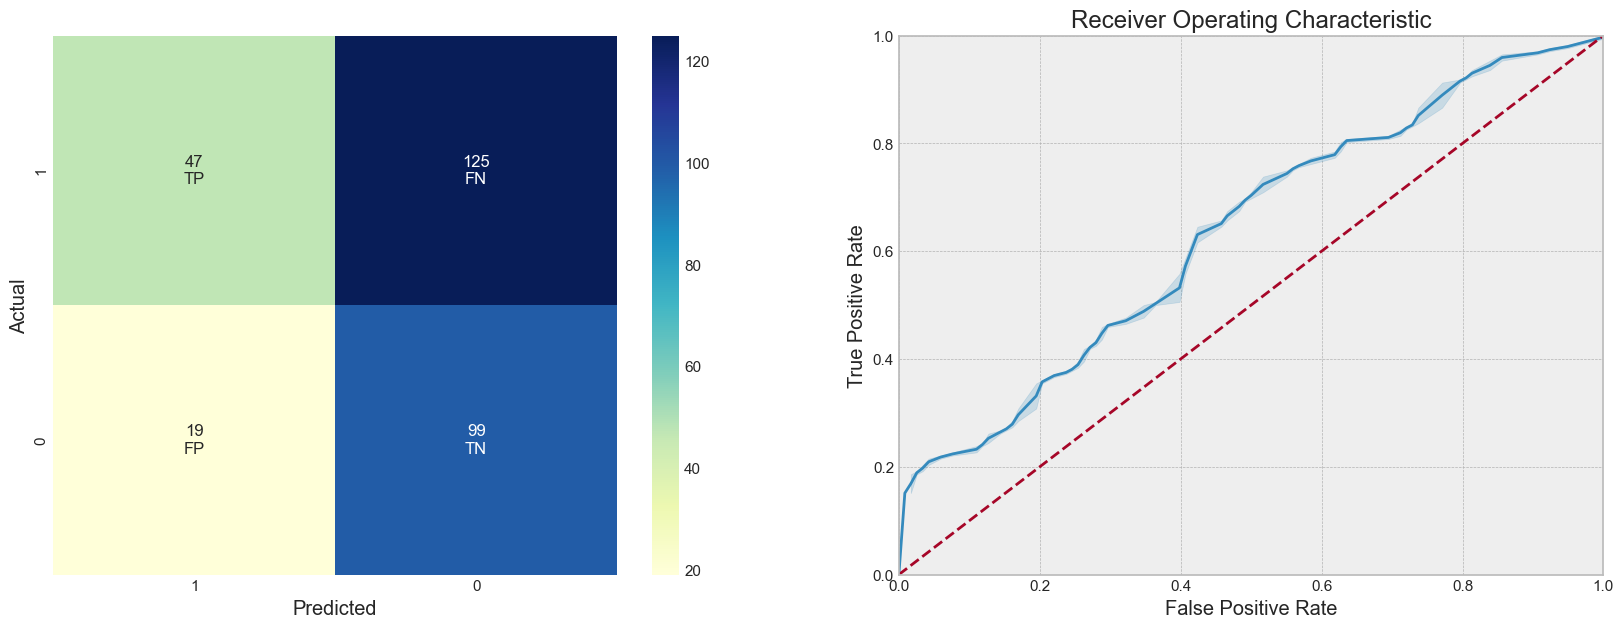

In [114]:
gnb = GaussianNB(priors=None, var_smoothing=1e-09)

parkinsons_disease_prediction("Gaussian Naïve Bayes", gnb, train_X, test_X, train_y, test_y, plot=True)

### Support Vector Classifier

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       118
           1       0.71      0.77      0.74       172

    accuracy                           0.68       290
   macro avg       0.67      0.66      0.66       290
weighted avg       0.67      0.68      0.68       290

Area under the curve:  0.6578143476547103


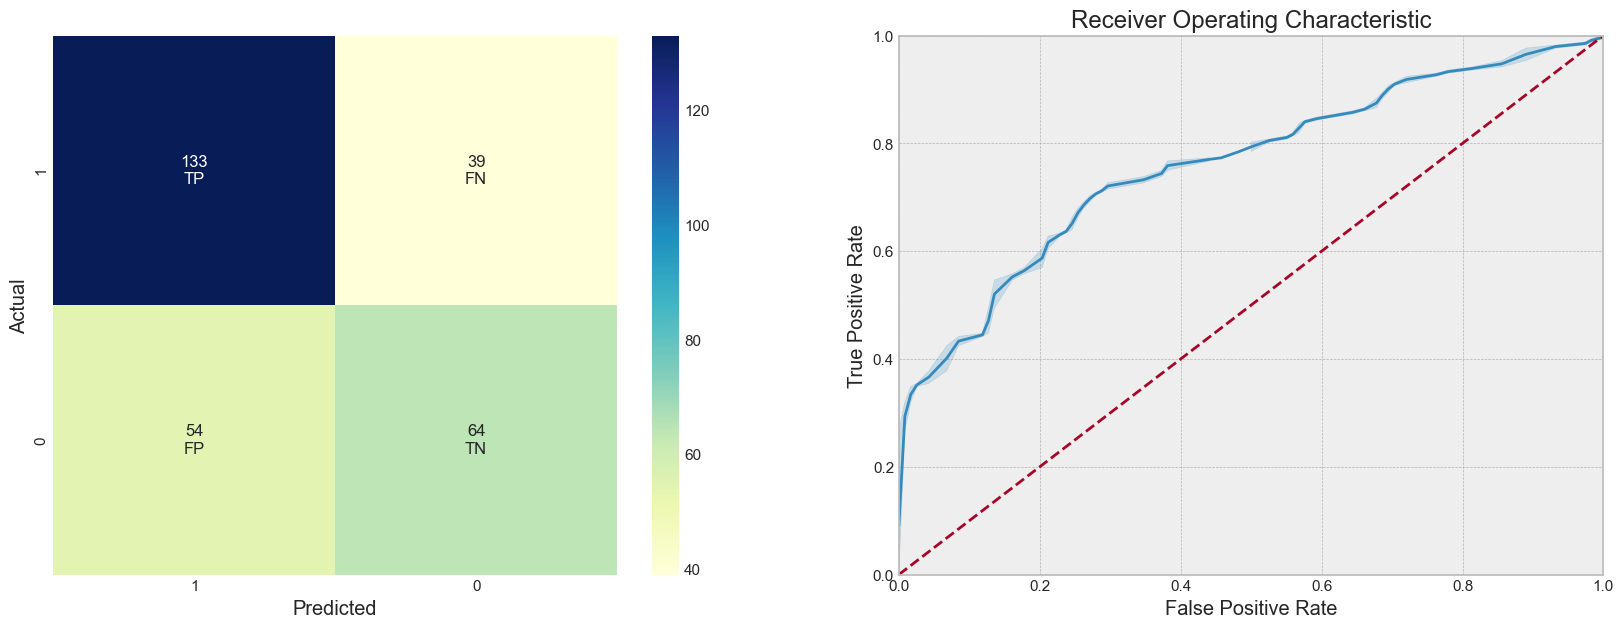

In [115]:
svc = SVC(C=1.0, kernel='linear', degree= 2, gamma=1.0, random_state=None,
          coef0=0.0, shrinking=True, probability=True,tol=0.001,
          cache_size=200, class_weight=None, verbose=False,max_iter= -1)

parkinsons_disease_prediction("Support Vector Classifier", svc, train_X, test_X, train_y, test_y, plot=True)

# Random Forest

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       118
           1       0.88      0.86      0.87       172

    accuracy                           0.84       290
   macro avg       0.84      0.84      0.84       290
weighted avg       0.85      0.84      0.85       290

Area under the curve:  0.8412495072920773


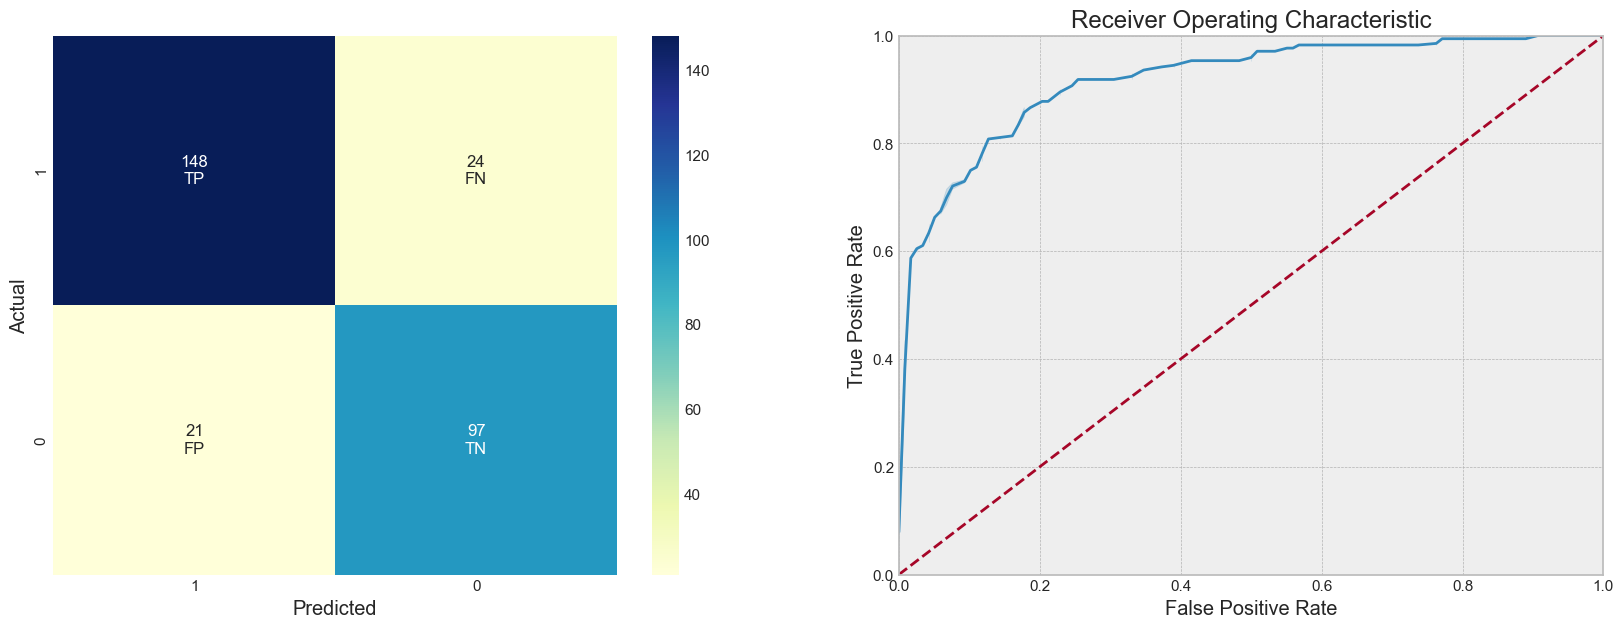

In [130]:
rnf = RandomForestClassifier(n_estimators=217, random_state=42)
parkinsons_disease_prediction("Random forest Classifier", rnf, train_X, test_X, train_y, test_y, plot=True)

# Light GBM

[LightGBM] [Info] Number of positive: 397, number of negative: 279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4323
[LightGBM] [Info] Number of data points in the train set: 676, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587278 -> initscore=0.352724
[LightGBM] [Info] Start training from score 0.352724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

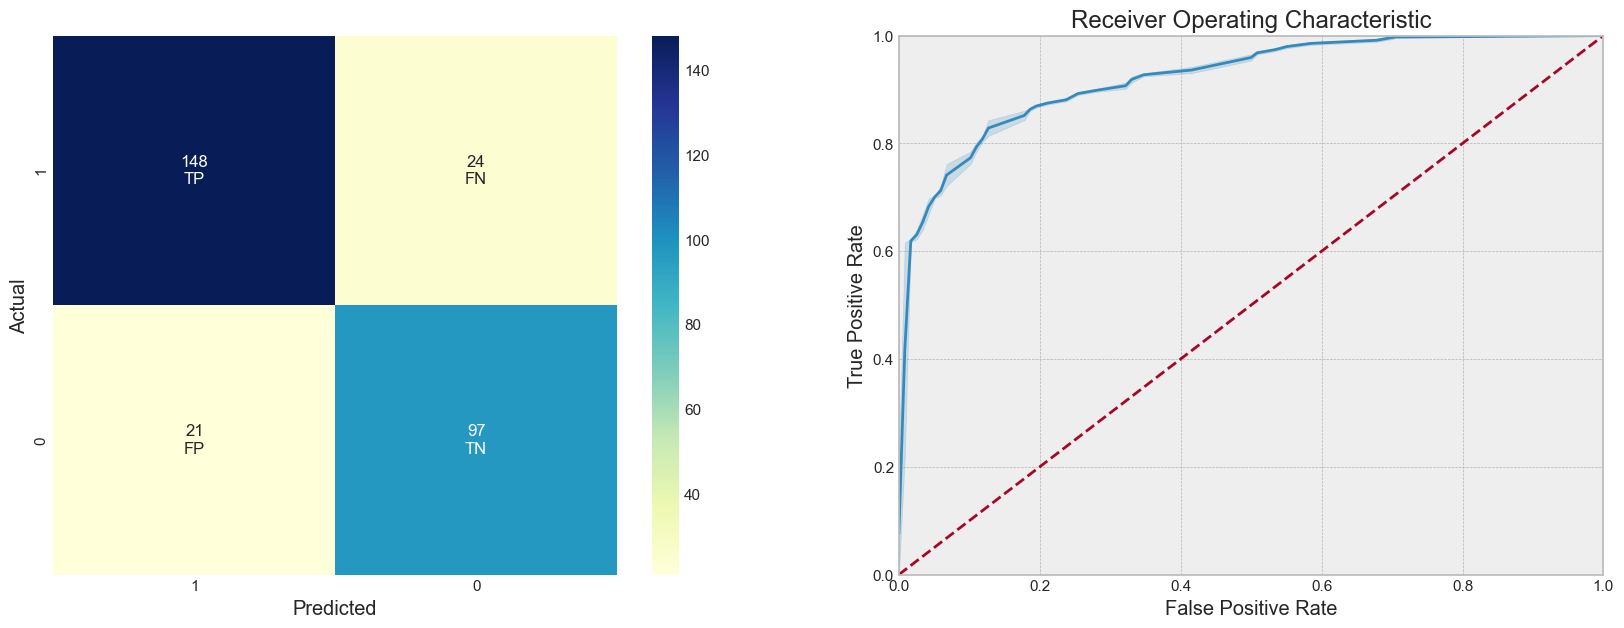

In [139]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=70, random_state=42)
parkinsons_disease_prediction("Light GBM", lgbm, train_X, test_X, train_y, test_y, plot=True)


## Stack and train meta-classifier

Accuracy: 0.65 (+/- 0.02) [Logistic Regression]
Accuracy: 0.63 (+/- 0.05) [KNN]
Accuracy: 0.64 (+/- 0.02) [Support Vector]
Accuracy: 0.73 (+/- 0.03) [Random Forest Classifier]
[LightGBM] [Info] Number of positive: 455, number of negative: 317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4749
[LightGBM] [Info] Number of data points in the train set: 772, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.589378 -> initscore=0.361396
[LightGBM] [Info] Start training from score 0.361396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

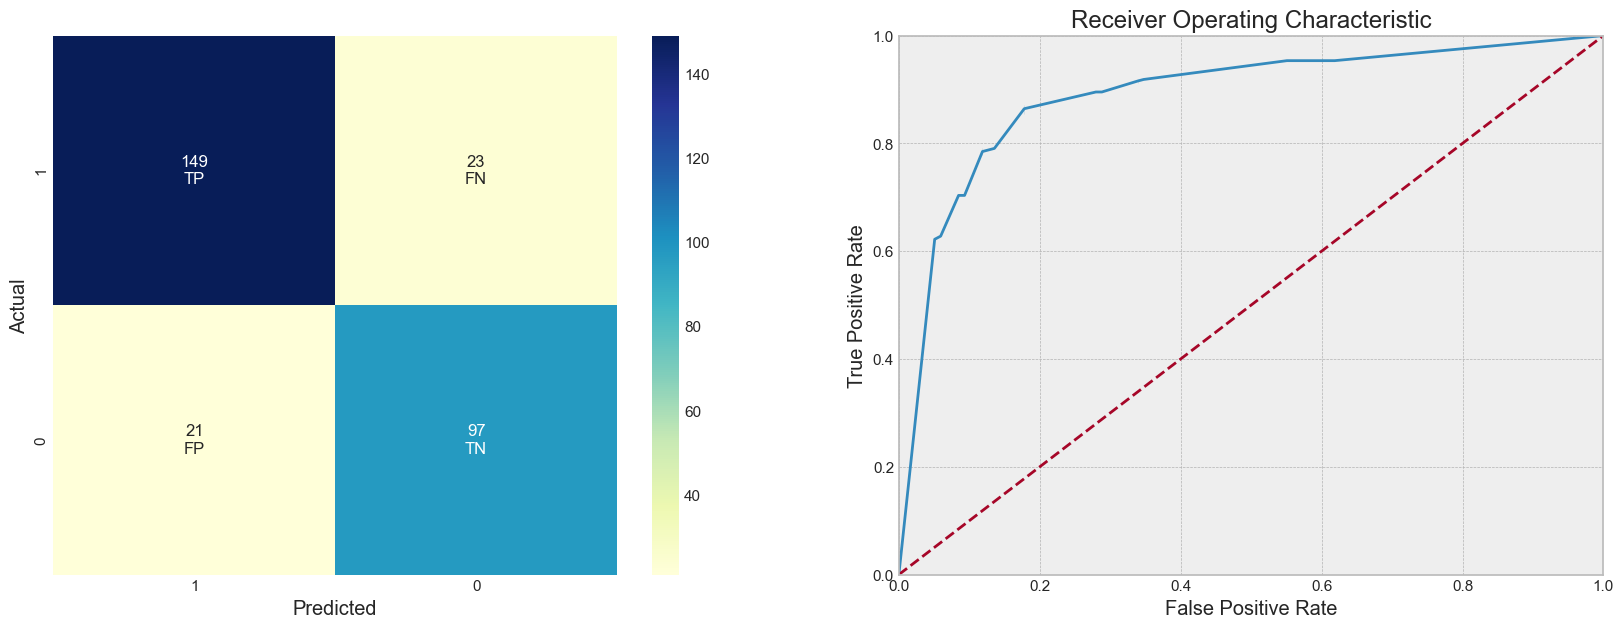

In [142]:
sclf = StackingCVClassifier(classifiers=[lr, knn, svc, rnf, lgbm],
                            meta_classifier=LogisticRegression(),
                            random_state=42)

for clf, label in zip([lr, knn, svc, rnf, lgbm, sclf], ["Logistic Regression" , 'KNN', 'Support Vector','Random Forest Classifier', 'Light GBM', 'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
print("\n")
parkinsons_disease_prediction("Stacking Classifier", sclf, train_X, test_X, train_y, test_y, plot=True)

## Ensemble models

### Random Forest

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       118
           1       0.83      0.83      0.83       172

    accuracy                           0.80       290
   macro avg       0.79      0.79      0.79       290
weighted avg       0.80      0.80      0.80       290

Area under the curve:  0.7928163184864013


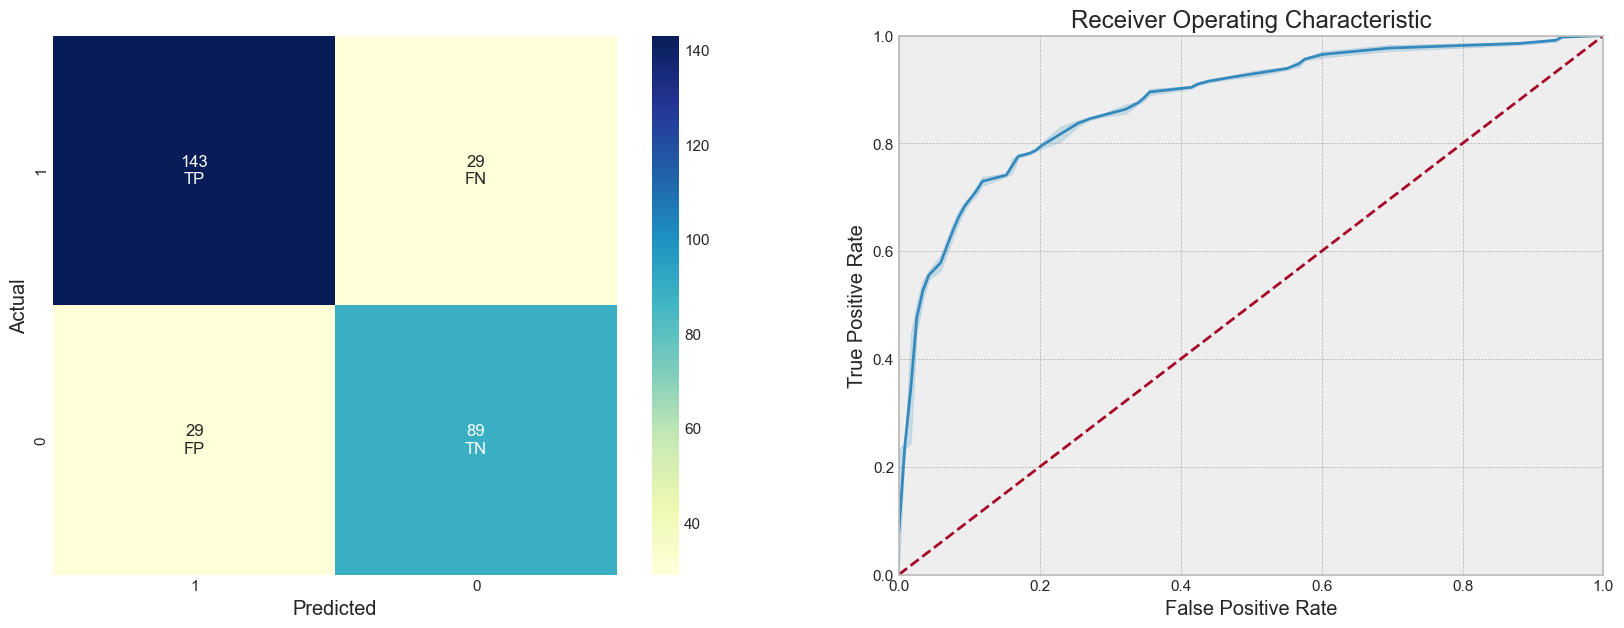

In [147]:
rfc = RandomForestClassifier(n_estimators = 300, max_depth = 5, criterion = "gini", 
                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                               warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

parkinsons_disease_prediction("Random Forest", rfc,train_X,test_X,train_y,test_y, plot=True)

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       118
           1       0.87      0.81      0.84       172

    accuracy                           0.82       290
   macro avg       0.81      0.82      0.81       290
weighted avg       0.82      0.82      0.82       290

Area under the curve:  0.8193240047299961


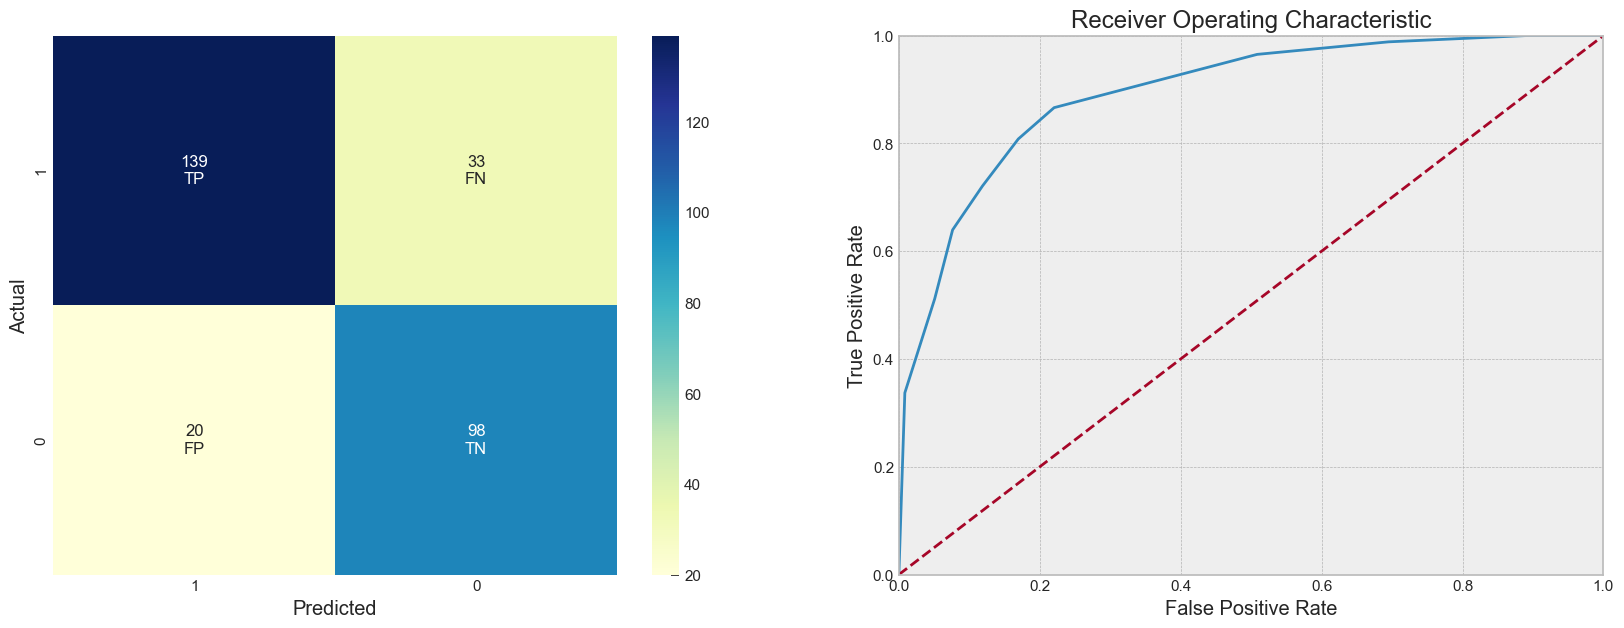

In [148]:
bcc = BaggingClassifier()

parkinsons_disease_prediction("Bagging Classifier", bcc,train_X,test_X,train_y,test_y, plot=True) 

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.58      0.64       118
           1       0.74      0.83      0.78       172

    accuracy                           0.73       290
   macro avg       0.72      0.71      0.71       290
weighted avg       0.72      0.73      0.72       290

Area under the curve:  0.7051635790303508


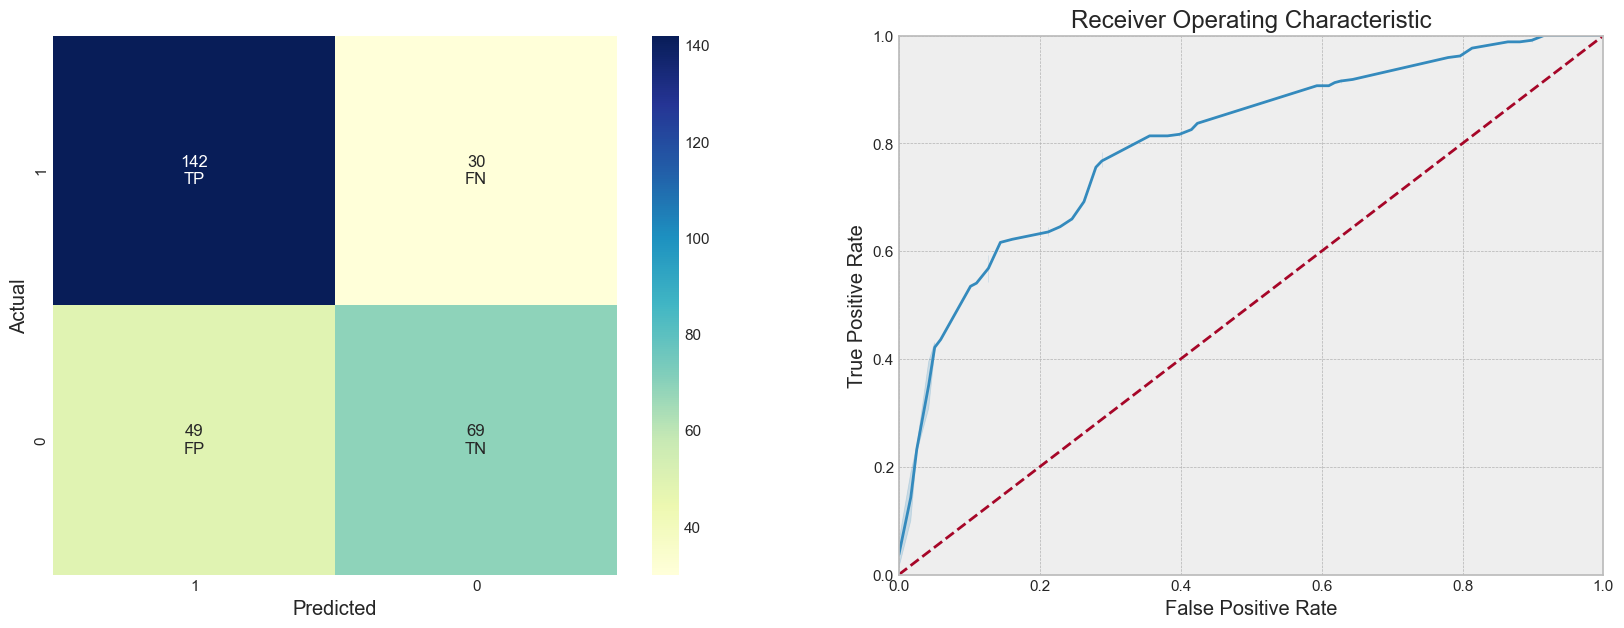

In [150]:
abc = AdaBoostClassifier(estimator=None, learning_rate=0.06, algorithm='SAMME.R')


parkinsons_disease_prediction("AdaBoost", abc, train_X, test_X, train_y, test_y, plot=True)

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       118
           1       0.85      0.84      0.85       172

    accuracy                           0.82       290
   macro avg       0.81      0.82      0.81       290
weighted avg       0.82      0.82      0.82       290

Area under the curve:  0.8155794245171464


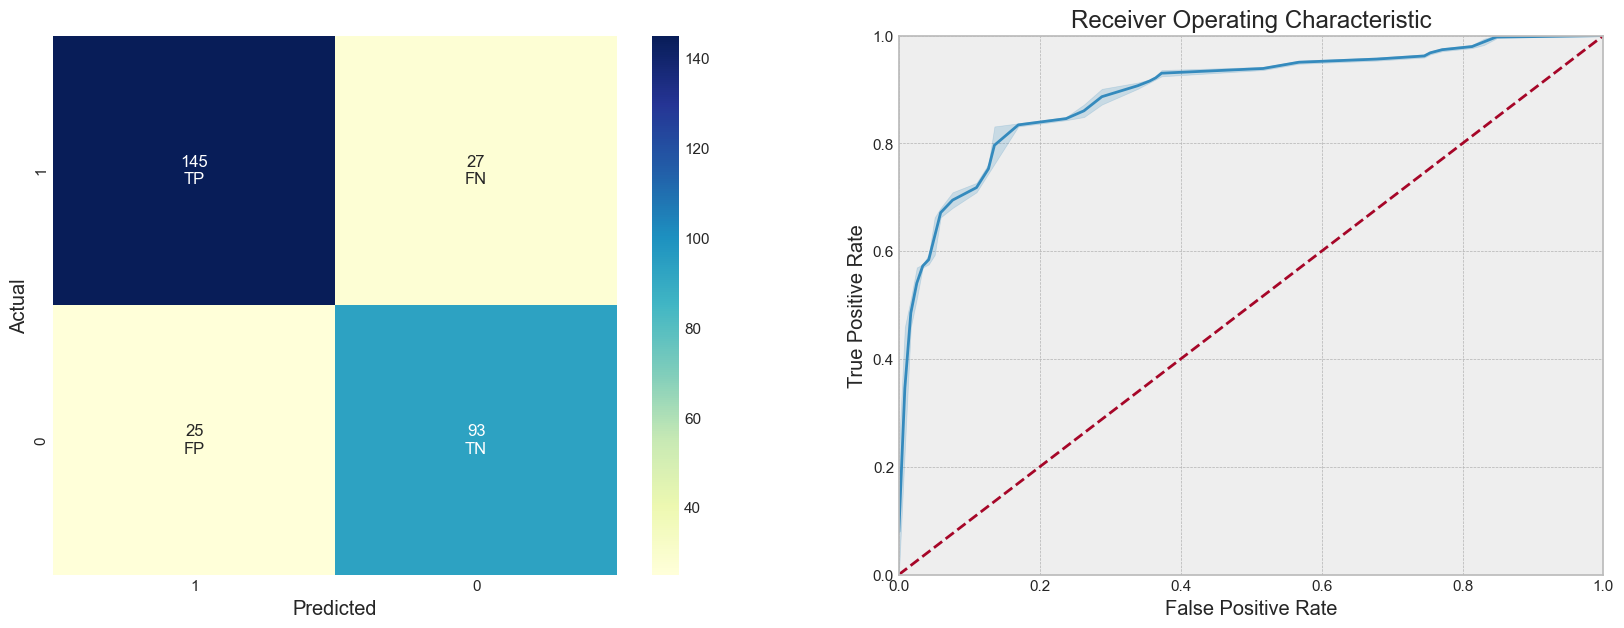

In [152]:
xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                        max_depth = 6, min_child_weight=1, n_estimators=50,
                        objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, subsample=0.8)

parkinsons_disease_prediction("XGBoost", xgc, train_X, test_X, train_y, test_y, plot=True)

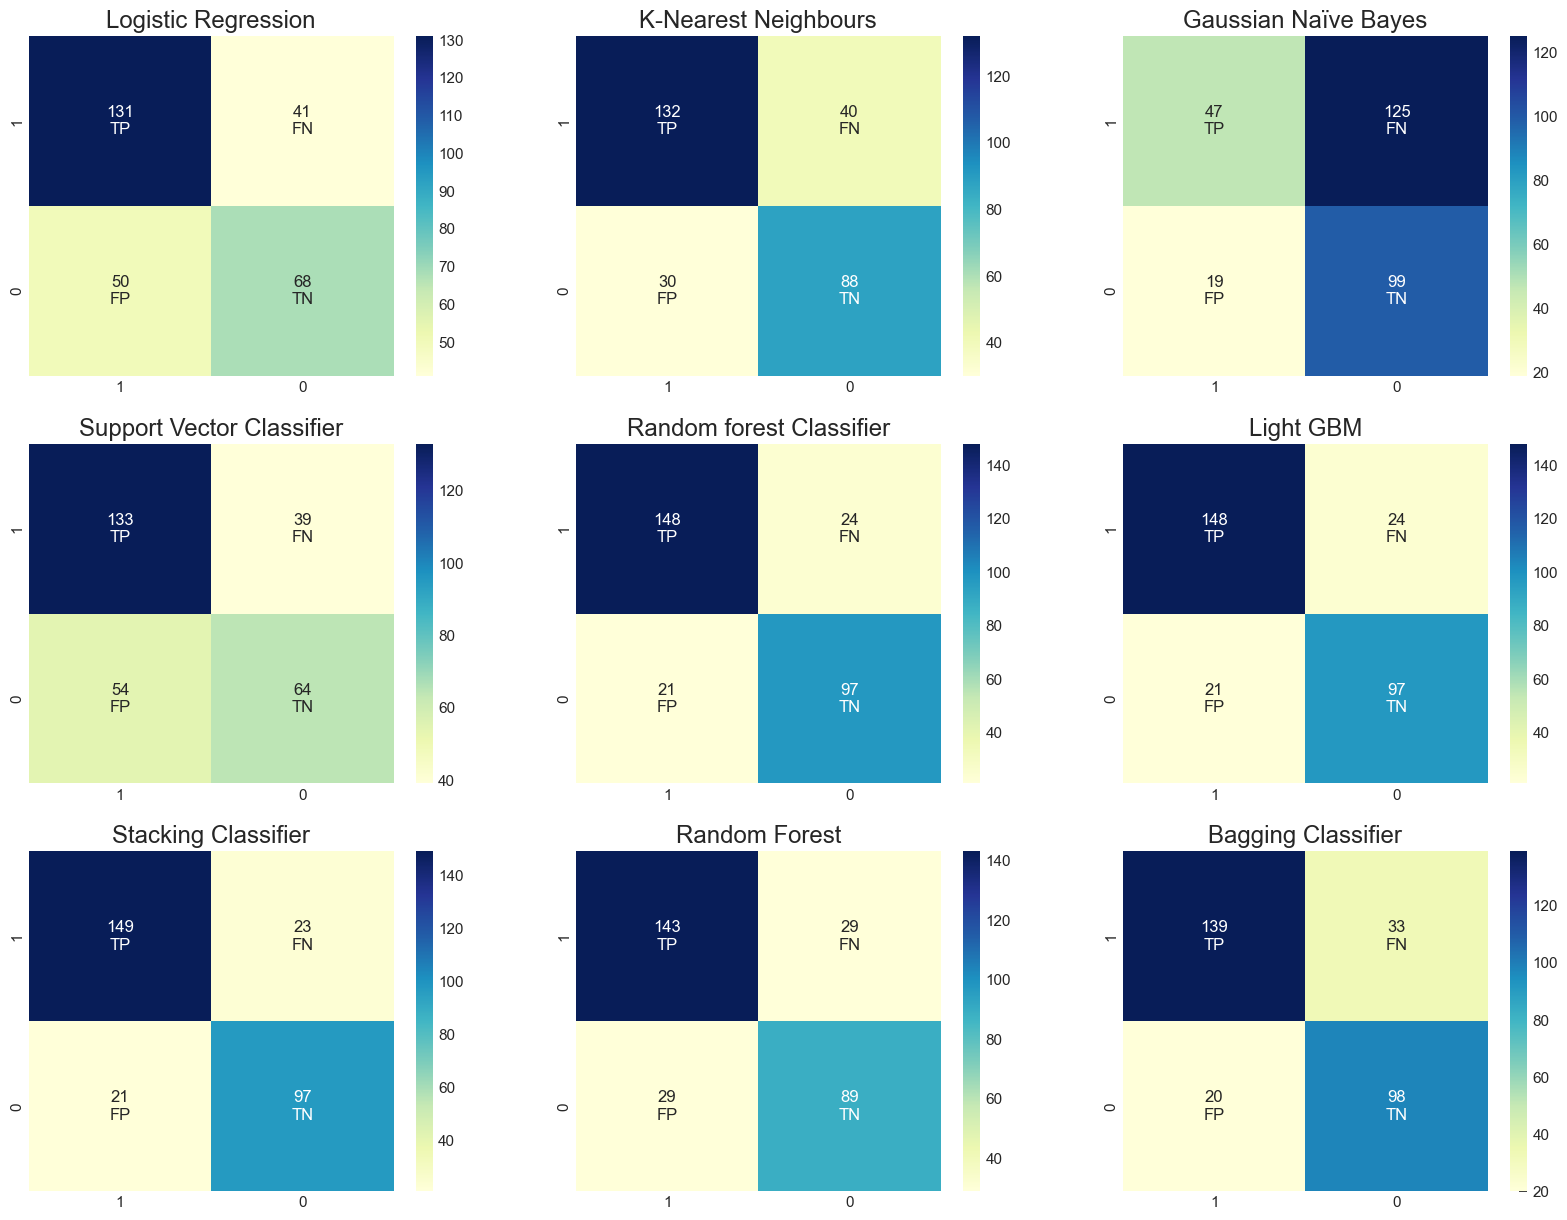

In [153]:
import math
fig, axes = plt.subplots(3,3, figsize = (20, 15))

cnt = 0
for r in range(4):
    for c in range(4):
        try:
            conf_matrix = np.flip(list(conf_matrix_all.values())[cnt])
            labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
            labels = np.core.defchararray.add(conf_matrix.astype(str), labels)

            sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[r, c], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);
            axes[r, c].set(title=list(conf_matrix_all.keys())[cnt])
            cnt += 1
        except:
            pass